**Importing Libraries**

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models

**Loading and preparing Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive/My Drive/Lung cancer detection/train"
class_list = sorted(os.listdir(train_path))
print(class_list)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [4]:
img_files = []
img_labels = []
image_classes = []

# Loop through each category in the training directory
for idx, category in enumerate(class_list):
    category_path = os.path.join(train_path, category)
    image_classes.append(category)
# Check all files in the category folder
    for file_name in os.listdir(category_path):
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(category_path, file_name)
            img_files.append(full_path)
            img_labels.append(idx)

img_files = np.array(img_files)
img_labels = np.array(img_labels)


**Data Info**

In [5]:
no_of_img = len(img_files)
print(f"Total number of images: {no_of_img}")

no_of_classes = len(np.unique(img_labels))
print(f"Total number of classes: {no_of_classes}")

Total number of images: 612
Total number of classes: 4


In [6]:
print("Classes:" , image_classes)

Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [7]:
unique_classes, counts = np.unique(img_labels, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"{image_classes[cls]}: {count} ")

adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 194 
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 
normal: 148 
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 


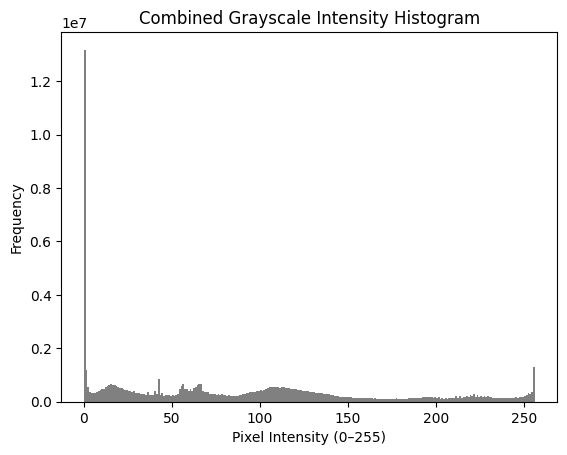

In [8]:
import cv2
import matplotlib.pyplot as plt

all_pixels = []

for img_path in img_files:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        all_pixels.extend(img.flatten())

all_pixels = np.array(all_pixels)

plt.hist(all_pixels, bins=256, range=(0, 256), color='gray')
plt.title("Combined Grayscale Intensity Histogram")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.show()

**Data Preprocessing**

In [9]:
augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),      # Flip images horizontally
    tf.keras.layers.RandomRotation(0.05),          # Small angle rotation
    tf.keras.layers.RandomZoom(0.05),              # Slight zoom in/out
    tf.keras.layers.RandomContrast(0.05),          # Adjust contrast slightly
])


# Function to read and process a single image
def load_and_process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Set channels=1 for grayscale
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # Normalize to [0, 1]
    return img, label

# Function to construct a TensorFlow dataset
def build_dataset(file_paths, file_labels, batch_size=16, shuffle_data=False, apply_augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=len(file_paths), seed=42)

    dataset = dataset.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if apply_augmentation:
        dataset = dataset.map(
            lambda image, label: (augmentation_pipeline(image, training=True), label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


**Building the Model**

In [10]:
def create_cnn_model():
    model_arch = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 categories
    ])

    model_arch.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model_arch


**Preparing the final model**

In [11]:
# Preparing the complete training dataset with shuffling and augmentation enabled
train_dataset = build_dataset(img_files, img_labels, shuffle_data=True, apply_augmentation=True)

model_final = create_cnn_model()

# Train the model over multiple epochs and track performance
training_history = model_final.fit(
    train_dataset,
    epochs=60,  # Adjust this as needed
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3776 - loss: 1.3676
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5772 - loss: 0.9454
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6170 - loss: 0.8345
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7309 - loss: 0.6653
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7218 - loss: 0.6850
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8024 - loss: 0.5203
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7748 - loss: 0.5271
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8222 - loss: 0.4447
Epoch 9/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8068 - loss: 0.4450
Epoch 10/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8208 - loss: 0.3960
Epoch 11/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8485 - loss: 0.4073
Epoch 12/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.85

**Visualising loss over epochs**

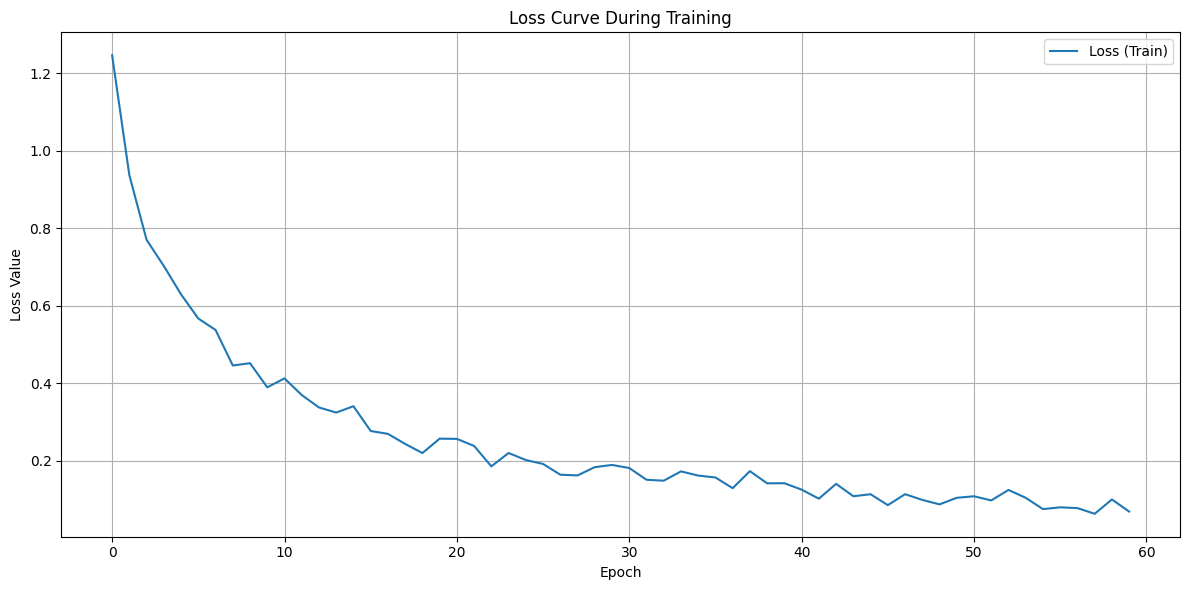

In [12]:
import matplotlib.pyplot as plt

# Visualize how the training loss evolves over time
plt.figure(figsize=(12, 6))
plt.plot(training_history.history['loss'], label='Loss (Train)')
plt.title('Loss Curve During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Testing the model**

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# validation directory path
val_path = "/content/drive/My Drive/Lung cancer detection/valid"
val_image_paths = []
val_labels = []

# List of class names
val_class_names = sorted(os.listdir(val_path))

for idx, category in enumerate(val_class_names):
    category_path = os.path.join(val_path, category)
    for file in os.listdir(category_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            val_image_paths.append(os.path.join(category_path, file))
            val_labels.append(idx)

val_image_paths = np.array(val_image_paths)
val_labels = np.array(val_labels)

eval_dataset = build_dataset(val_image_paths, val_labels, shuffle_data=False, apply_augmentation=False)

# Run model
predicted_probabilities = model_final.predict(eval_dataset)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Display performance metrics
conf_matrix = confusion_matrix(val_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

eval_report = classification_report(val_labels, predicted_classes, target_names=val_class_names)
print("Classification Report:\n", eval_report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Confusion Matrix:
 [[20  0  0  3]
 [ 2 18  0  1]
 [ 0  1 12  0]
 [ 3  0  0 12]]
Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.80      0.87      0.83        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.95      0.86      0.90        21
                                          normal       1.00      0.92      0.96        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.75      0.80      0.77        15

                                        accuracy                           0.86        72
                                       macro avg       0.87      0.86      0.87        72
                                    weighted avg       0.87      0.86      0.86        72



**Finalise the model**

In [14]:
model_final.save('m86acc.keras')
